In [1]:
## Libraries 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
import datetime
from IPython.display import clear_output

2024-02-18 16:50:35.166529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 16:50:35.166613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 16:50:35.168400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_images(dirname, data_size):
    X, Y = [], []
    for filename in tqdm(os.listdir(dirname)):
        if len(X) == data_size + 20:
            break
        im = Image.open(os.path.join(dirname, filename))
        Y.append(np.array(im))
        im = im.resize((128,128))
        X.append(np.array(im))
    return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

def normalize_images(images):
    return (images / 127.5) - 1

def split_data(X, Y, data_size):
    X_train = X[:data_size].reshape(-1,1,128,128,3)
    Y_train = Y[:data_size].reshape(-1,1,256,256,3)
    X_test = X[data_size:].reshape(-1,1,128,128,3)
    Y_test = Y[data_size:].reshape(-1,1,256,256,3)
    return X_train, Y_train, X_test, Y_test


data_size = 1000
dirname = "/kaggle/input/mscoco/mscoco_resized/train2014"
X, Y = load_images(dirname, data_size)
X, Y = normalize_images(X), normalize_images(Y)
X_train, Y_train, X_test, Y_test = split_data(X, Y, data_size)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

  1%|          | 1020/82783 [00:03<04:27, 305.27it/s]


(1000, 1, 128, 128, 3) (1000, 1, 256, 256, 3) (20, 1, 128, 128, 3) (20, 1, 256, 256, 3)


In [4]:
## downsampling the image 
def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

## upsampling the image
def upsample(filters, size, apply_dropout = True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [5]:
def create_downsample():
    return [
        downsample(64, 4, apply_batchnorm = False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

def create_upsample():
    return [
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
    ]

def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    down_stack = create_downsample()
    up_stack = create_upsample()

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=4, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

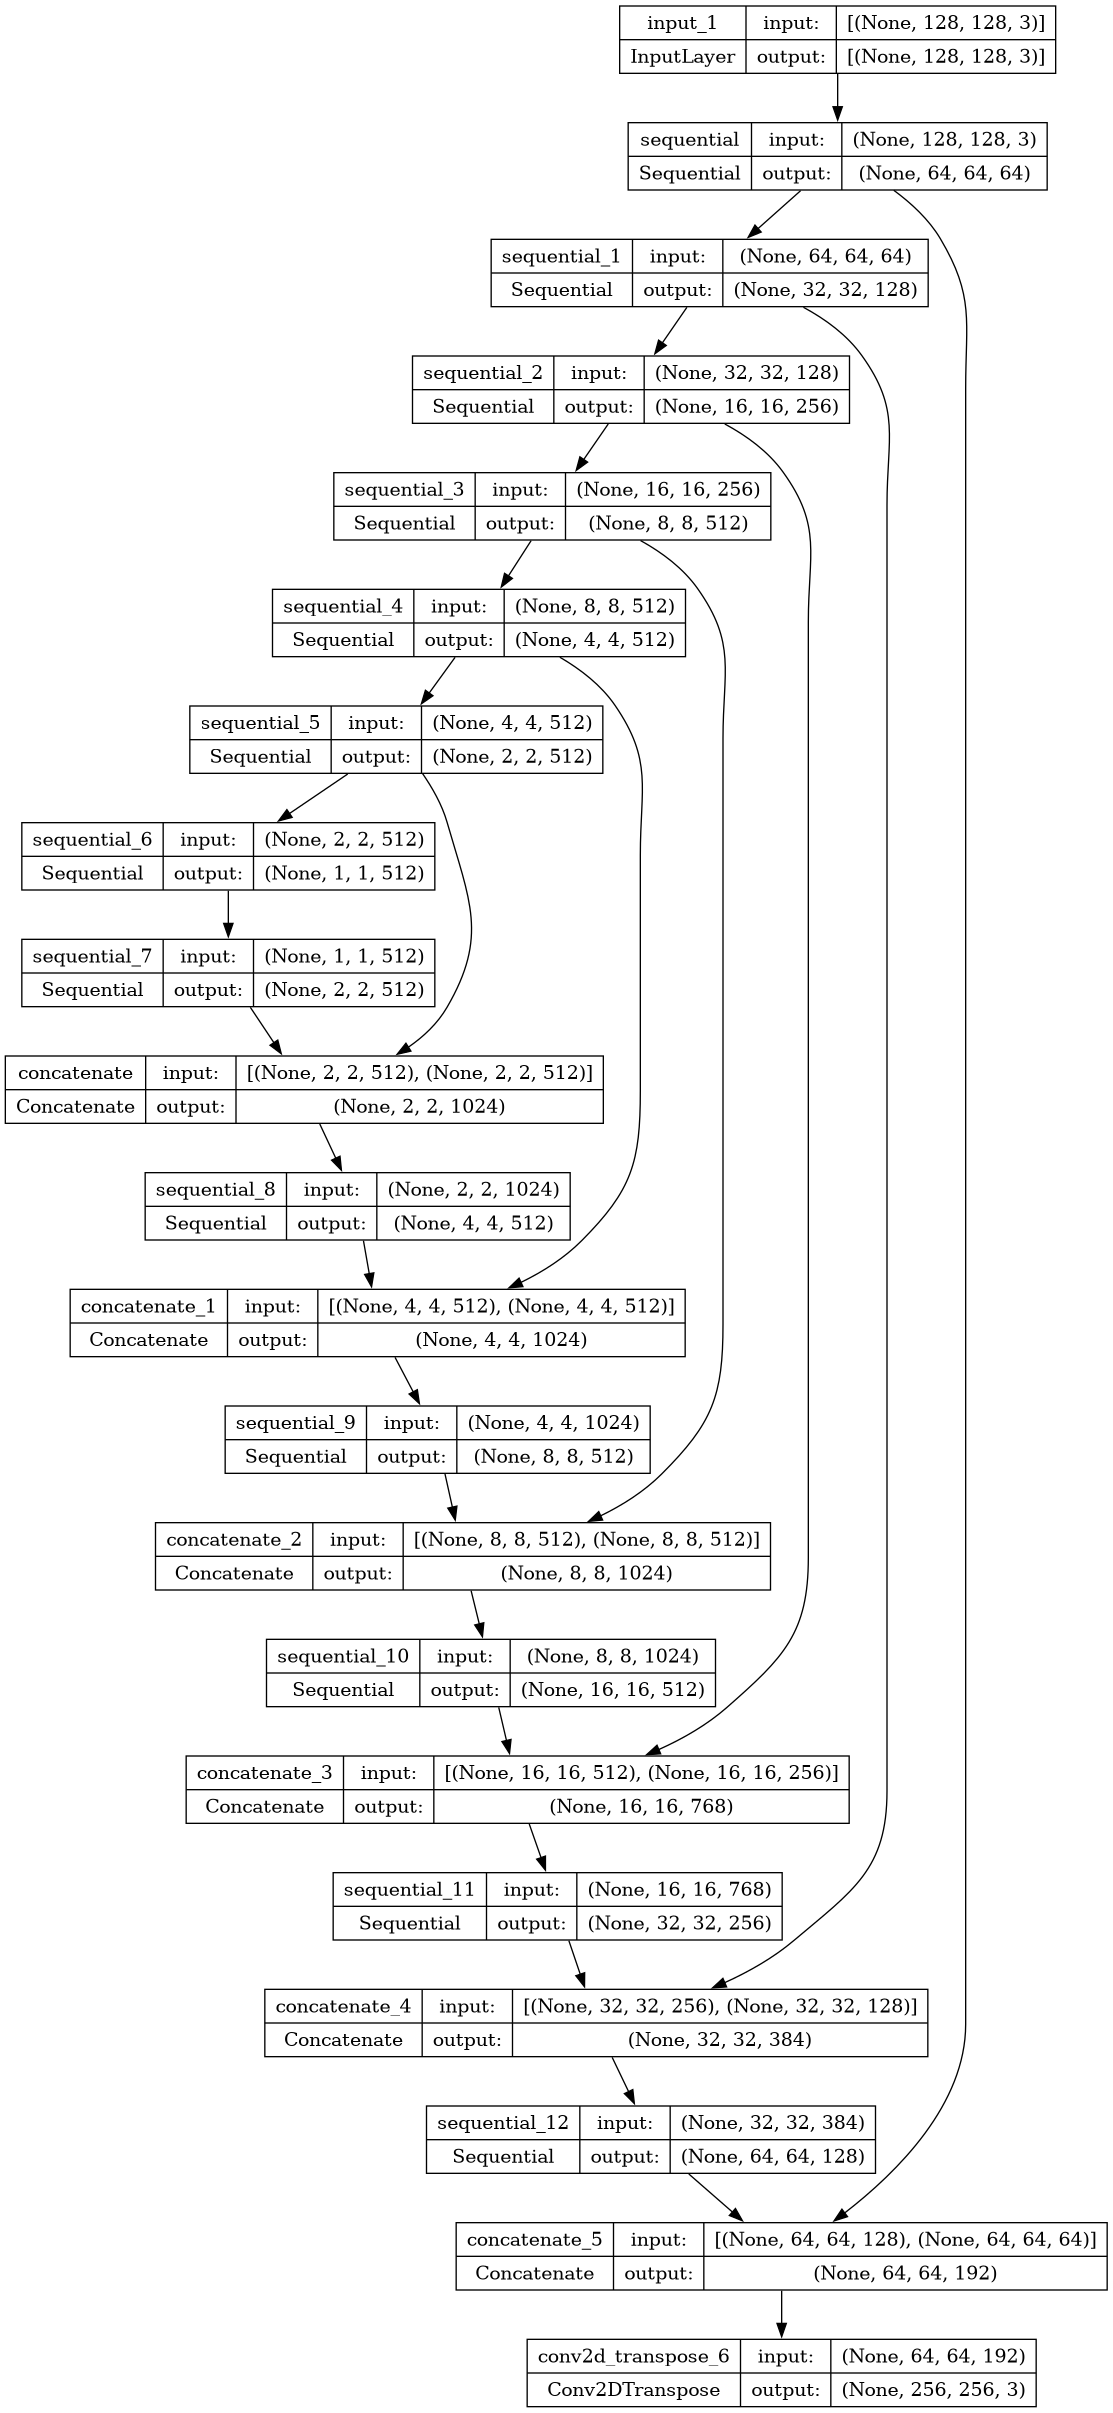

In [6]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True)

In [7]:
# Set the weight for the L1 loss term (lambda)
LAMBDA = 500

# Define the loss function for the generator
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # GAN loss measures how well the generator was able to trick the discriminator
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 loss measures the absolute differences between the target and the generated images
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # The total generator loss is the sum of the GAN loss and the weighted L1 loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [8]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[128,128,3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')
    
    inp_resized = tf.image.resize(inp, (256,256), method = 'bicubic')
    
    x = tf.keras.layers.concatenate([inp_resized,tar]) #(bs,256,256,6)
    x = downsample(64,4,False)(x) #(bs,128,128,64)
    x = downsample(128,4)(x) #(bs,64,64,128)
    x = downsample(256,4)(x) #(bs,32,32,256)
    
    x = tf.keras.layers.ZeroPadding2D()(x) #(bs,34,34,256)
    x = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(x) #(bs,31,31,512)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x) #(bs,33,33,512)
    x = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(x) #(bs,30,30,1)
    
    return tf.keras.Model(inputs = [inp,tar], outputs = x)

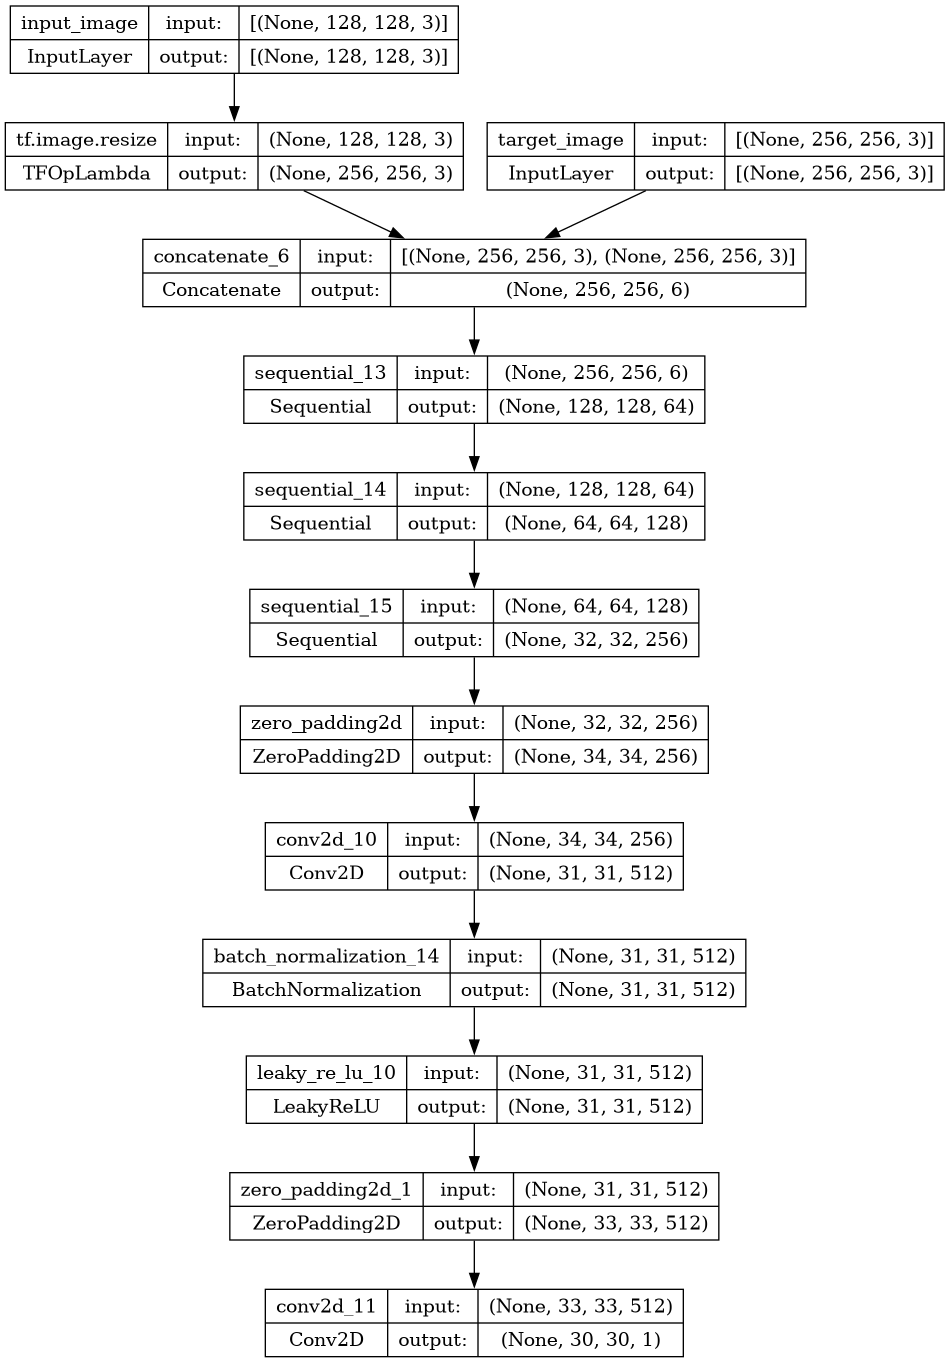

In [9]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [10]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    return real_loss + gen_loss

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [12]:
## GENERATE IMAGES
def generate_images(model, inp, tar):
    inp_normalized = (inp/127.5)-1
    pred = model(inp_normalized, training = True)
    pred = (pred+1)*127.5
    
    pred = Image.fromarray(tar[0].astype('uint8'),'RGB')
    pred = pred.resize((200,200))
    pred = np.array(pred).reshape((1,200,200,3))
    display_list = [np.array(inp[0], dtype='int'),np.array(pred[0], dtype='int'),np.array(tar[0], dtype='int')]
    title_list = ['input','prediction','target']
    plt.figure(figsize = (20,20))
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    
    plt.show()

In [13]:
## TRAINING 
EPOCHS = 5
@tf.function
def train_step(inp, tar, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(inp, training = True)
        
        disc_real_output = discriminator([inp,tar], training = True)
        disc_gen_output = discriminator([inp,gen_output], training = True)
        
        gen_loss = generator_loss(disc_gen_output, gen_output, tar)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
    
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

def fit(X_train, Y_train, X_test, Y_test, epochs):
    for epoch in range(epochs):
        clear_output(wait = True)
        
        #generate_images(generator, (X_test[0]+1)*127.5, (Y_test[0]+1)*127.5)

        print("Epoch : ", epoch)
        
        for inp,tar in tqdm(zip(X_train,Y_train)):
            train_step(inp,tar,epoch)
        
        if (epoch+1)%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
    checkpoint.save(file_prefix=checkpoint_prefix)

fit(X_train, Y_train, X_test, Y_test, EPOCHS)

Epoch :  4


1000it [19:40,  1.18s/it]


In [ ]:
generate_images(generator, (X_test[1]+1)*127.5, (Y_test[1]+1)*127.5)